In [1]:
import matplotlib
matplotlib.use('Agg')

# This will be removed from the proper script
%matplotlib inline

import glob
import os
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd

Need to extract MJD from the header.
Need to dedisperse for multiple DMs - include some DM cutoff where SNR is found again
File naming convention timestamp_beamid_dm.jpg
Add extra information to the .spccl file, includng corresponding .fil file, beam number, RA, Dec and the PNG

In [2]:
import threading
from astropy.time import Time
import json
import struct

In [88]:
# This class does the actual plotting

class Plotter:
    
    def __init__(self, timing, verbose, outdir = './'):
        self._timing = timing
        self._verbose = verbose
        # 2.5s padding in MJD at the start and end of candidate file
        self._pad = 2.5 / 86400.0
        self._timeavg = 16
        self._freqavg = 16
        self._nchans = 4096
        self._tsamp = 306.24299e-06 # in s
        self._ftop = 1712.104492
        self._fband = -0.208984
        self._fbottom = self._ftop + self._nchans * self._fband
        self._outdir = outdir
        self._beam_colours = ['firebrick', 'deepskyblue', 'darkorange', 'limegreen', 'purple', 'darkgrey']
        self._disp_const = 4.15e+03 * (1.0 / (self._fbottom * self._fbottom) - 1.0 / (self._ftop * self._ftop)) # in s
        
        if self._verbose:
            print("Starting the plotter up")
    
    def Dedisperse(self, inputdata, dm):
    
        dm_start = time.time()

        outbands = 1
        perband = int(self._nchans / outbands)
        fulldelay = self._disp_const * dm
        fullsampdelay = int(np.ceil(fulldelay / self._tsamp))
        padding = np.ceil(0.25 / self._tsamp)
        sampuse = int(padding * 2) + fullsampdelay
        sampout = int(padding * 2)
        
        dedispersed = np.zeros((outbands, sampout))
        
        #print("File length: %d, max dispersion: %d, padding samples: %d, output samples %d" % (inputdata.shape[1], fullsampdelay, padding, sampout))
        
        band = 0
        
        if ((int(padding) + fullsampdelay + sampout) < inputdata.shape[1]):
            
            for chan in np.arange(perband):
                chanfreq = self._ftop + chan * self._fband
                delay = int(np.round(4.15e+03 * dm * (1.0 / (chanfreq * chanfreq) - 1.0 / (self._ftop * self._ftop)) / self._tsamp))
                dedispersed[band, :] = np.add(dedispersed[band, :], inputdata[chan, int(padding) + delay : int(padding) + delay + sampout])
                

        
        else:
            print("We got something wrong: need more samples than there is in the data")
        
        dm_end = time.time()
        
        if (self._verbose):
            print("Dedispersion took %.2fs" % (dm_end - dm_start))

        return dedispersed
    
    def PlotFullCands(self, candidates):
        
        cmap = matplotlib.colors.ListedColormap(self._beam_colours)
        bound = [0, 1, 2, 3 , 4, 5, 6]
        
        norm = matplotlib.colors.BoundaryNorm(bound, cmap.N, clip=True)
    
        print("Plotting the full candidates")
        skip_lines = 1
        #candidates = pd.read_csv(candfile, skiprows=1, sep='\t', header=None, names=header_names)
        
        figspccl = plt.figure(figsize=(15,10))
        axspccl = figspccl.gca()
        axspccl.ticklabel_format(useOffset=False)
        candsc = axspccl.scatter(x=candidates['MJD'], y=candidates['DM'] + 1, s=candidates['SNR'], c=candidates['Beam'], norm=norm, cmap=cmap)
        axspccl.set_xlim(candidates['MJD'].values[0] - self._pad, candidates['MJD'].values[-1] + self._pad)
        axspccl.set_xlabel('MJD', fontsize=14, weight='bold')
        axspccl.set_ylabel('DM', fontsize=14, weight='bold')
        axspccl.set_yscale('log')
        sccbar = figspccl.colorbar(candsc)
        sccbar.set_label('SNR', fontsize=14, weight='bold')
        figspccl.savefig(self._plotdir + '/full_candidates.png')
        plt.close(figspccl)
    
    def PlotExtractedCand(self, beam_dir, filename, headsize, nchans, properties, ibeam=0):
        
        mask = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        
        
        # Read original data
        basename = filename[:-4]
        fildata = np.reshape(np.fromfile(beam_dir + filename, dtype='B')[headsize:], (-1, nchans)).T
        print("Read %d time samples" % (fildata.shape[1]))
        fildata = fildata * mask[:, np.newaxis]
        # Time average the data
        timesamples = int(np.floor(fildata.shape[1] / self._timeavg) * self._timeavg)
        filtimeavg = fildata[:, :timesamples].reshape(fildata.shape[0], (int)(timesamples / self._timeavg), self._timeavg).sum(axis=2)
        
        
        # Frequency average the data
        frequencies = int(np.floor(fildata.shape[0] / self._freqavg) * self._freqavg)
        filfreqavg = fildata[:frequencies, :timesamples].reshape(-1, self._freqavg, timesamples).sum(axis=1)
        
        # Both averages
        filbothavg = filfreqavg.reshape(filfreqavg.shape[0], (int)(timesamples / self._timeavg), self._timeavg).sum(axis=2) / self._timeavg / self._freqavg
        
        filbothavgband = np.mean(filbothavg, axis=1)
        
        notzero = (filbothavg[:,0])[np.where(filbothavg[:,0]!=0)[0]]
        datamean = np.mean(notzero)
        datastd = np.std(notzero)

        ctop = int(np.ceil(datamean + 1.25 * datastd))
        cbottom = int(np.floor(datamean - 0.5 * datastd))
        
        fmt = lambda x: "{:.2f}".format(x)
        
        # Prepare the frequency ticks
        orig_freq_pos = np.linspace(0, 4096, num=9)
        orig_freq_pos[-1] = orig_freq_pos[-1] - 1
        avg_freq_pos = np.linspace(0, int(nchans / self._freqavg), num=9)
        avg_freq_pos[-1] = avg_freq_pos[-1] - 1
        
        orig_freq_label = self._ftop + orig_freq_pos * self._fband
        orig_freq_label_str = [fmt(label) for label in orig_freq_label]
        
        avg_freq_label = self._ftop + avg_freq_pos * self._fband * self._freqavg
        avg_freq_label_str = [fmt(label) for label in avg_freq_label]
        
        # Prepare the time ticks
        orig_time_pos = np.linspace(0, fildata.shape[1], num=9)
        avg_time_pos = np.linspace(0, (int)(timesamples / self._timeavg), num=5)
        
        orig_time_label = orig_time_pos * self._tsamp
        orig_time_label_str = [fmt(label) for label in orig_time_label]
        
        avg_time_label = avg_time_pos * self._tsamp * self._timeavg
        avg_time_label_str = [fmt(label) for label in avg_time_label]
        
        #plot_fig, plot_axis = plt.subplots(2, 2, figsize=(11.69,8.27), dpi=75)
        #plot_fig, plot_axis = plt.subplots(2, 2, figsize=(8.3,5.8), dpi=75)
        
        #cmap='binary'
        #filbothavg = np.ma.masked_where(filbothavg < 75, filbothavg)
        #cmap = plt.cm.OrRd
        #cmap.set_bad(color='black')
        
        cmap = 'binary'
        
        fil_fig, fil_axis = plt.subplots(2, 1, figsize=(11.69,8.27), dpi=75)
        fil_fig.tight_layout(h_pad=3.25, rect=[0, 0.03, 1, 0.95])
        
        axboth = fil_axis[0]
        axboth.imshow(filbothavg, interpolation='none', vmin=cbottom, vmax=ctop, aspect='auto', cmap=cmap)
        axboth.set_title('Time (' + str(self._timeavg) + '), freq (' + str(self._freqavg) + ') avg', fontsize=11)
        axboth.set_xlabel('Time [s]', fontsize=10)
        axboth.set_ylabel('Frequency [MHz]', fontsize=10)
        axboth.set_xticks(avg_time_pos)
        axboth.set_xticklabels(avg_time_label_str, fontsize=8)
        axboth.set_yticks(avg_freq_pos)
        axboth.set_yticklabels(avg_freq_label_str, fontsize=8)        

        dedispersed = self.Dedisperse(fildata, properties['DM'])
        
        dedisp_time_pos = np.linspace(0, dedispersed.shape[1], num=9)
        dedisp_time_label = dedisp_time_pos * self._tsamp
        dedisp_time_label_str = [fmt(label) for label in dedisp_time_label]
        
        axdedisp = fil_axis[1]
        axdedisp.plot(dedispersed[0, :], linewidth=0.4, color='black')
        fmtdm = "{:.2f}".format(properties['DM'])
        axdedisp.set_title('Dedispersed time series, DM ' + fmtdm)
        axdedisp.set_xticks(dedisp_time_pos)
        axdedisp.set_xticklabels(dedisp_time_label_str)
        axdedisp.set_xlabel('Time [s]')
        axdedisp.set_ylabel('Power [arbitrary units]')
        
        if (np.sum(dedispersed) == 0):
            axdedisp.text(0.5, 0.6, 'Not dedispersed - please report!', fontsize=14, weight='bold', color='firebrick',  horizontalalignment='center', verticalalignment='center', transform=axdedisp.transAxes)
        
        plotdir = self._outdir + '/beam-' + str(ibeam) + '/Plots/'
        
        fil_fig.savefig(plotdir + str(properties['MJD']) + '_DM_' + fmtdm + '_beam_' + str(ibeam) + '.jpg', bbox_inches = 'tight', quality=75)
        
        plt.close(fil_fig)
        
        
        #plot_fig.tight_layout(h_pad=3.25, rect=[0, 0.03, 1, 0.95])
        
        #axmain = plot_axis[0, 0]
        #axtime = plot_axis[0, 1]
        #axfreq = plot_axis[1, 0]
        #axboth = plot_axis[1, 1]
        

        
        
        # That's just a basic plot
        #prop_str = 'DM: ' + str(properties['DM']) + ', SNR: ' + str(properties['SNR']) 
        #plot_fig.suptitle('UTC: ' + basename + ', beam ' + str(ibeam) + ', ' + prop_str, weight='bold')
        #axmain.imshow(fildata, aspect='auto', cmap=cmap)
        #axmain.set_title('Original', fontsize=11)
        #axmain.set_xlabel('Time [s]', fontsize=10)
        #axmain.set_ylabel('Frequency [MHz]', fontsize=10)
        #axmain.set_xticks(orig_time_pos)
        #axmain.set_xticklabels(orig_time_label_str, fontsize=8)
        #axmain.set_yticks(orig_freq_pos)
        #axmain.set_yticklabels(orig_freq_label_str, fontsize=8)
        
        # Time averaged plot
        #axtime.imshow(filtimeavg, aspect='auto', cmap=cmap)
        #axtime.set_title('Time avg', fontsize=11)
        #axtime.set_xlabel('Time [s]', fontsize=10)
        #axtime.set_xticks(avg_time_pos)
        #axtime.set_xticklabels(avg_time_label_str, fontsize=8)
        #axtime.set_yticks(orig_freq_pos)
        #axtime.set_yticklabels(orig_freq_label_str, fontsize=8)
        
        # Frequency averaged plot
        #axfreq.imshow(filfreqavg, aspect='auto', cmap=cmap)
        #axfreq.set_title('Freq avg', fontsize=11)
        #axfreq.set_xlabel('Time [s]', fontsize=10)
        #axfreq.set_ylabel('Frequency [MHz]', fontsize=10)
        #axfreq.set_xticks(orig_time_pos)
        #axfreq.set_xticklabels(orig_time_label_str, fontsize=8)
        #axfreq.set_yticks(avg_freq_pos)
        #axfreq.set_yticklabels(avg_freq_label_str, fontsize=8)
        
        # Both averaged
        #axboth.imshow(filbothavg, aspect='auto', cmap=cmap)
        #axboth.set_title('Both avg', fontsize=11)
        #axboth.set_xlabel('Time [s]', fontsize=10)
        #axboth.set_xticks(avg_time_pos)
        #axboth.set_xticklabels(avg_time_label_str, fontsize=8)
        #axboth.set_yticks(avg_freq_pos)
        #axboth.set_yticklabels(avg_freq_label_str, fontsize=8)

        #dedispersed = self.Dedisperse(fildata, properties['DM'])
        #axdedisp.plot(dedispersed[0, :])
        
        #plot_fig.savefig('PNGs/' + basename + '_beam_' + str(ibeam) + '.jpg', bbox_inches = 'tight', quality=75)
        #plt.close(plot_fig)
                
        #plot_dedisp = plt.figure(figsize=(11.69,8.27), dpi=75)
        #ax_dedisp = plot_dedisp.gca()
        #ax_dedisp.plot(dedispersed[0, :])
        #ax_dedisp.set_title('UTC: ' + basename + ', beam ' + str(ibeam) + ', ' + prop_str, weight='bold')
        #plot_dedisp.savefig('PNGs/' + basename + '_beam_' + str(ibeam) + '_dedispersed_dm' + str(properties['DM']) + '.jpg', bbox_inches = 'tight', quality=75)
        #plt.close(plot_dedisp)
        
    def PlotDist(self, filename, selected):
        print("Kill me...")
        

In [89]:
# This is an overarching class that watches the directories and detects any changes

class Watcher:
    
    def __init__(self, indir, timing=True, verbose=False):
        self._directory = indir
        self._timing = timing
        self._verbose = verbose
        self._watching = True
        self._nchans = 4096
        self._headsize = 136
        self._nbeams = 6
        self._header_names = ['MJD', 'DM', 'Width', 'SNR']
        self._start_time = time.time()
        self._mjd_pad = 0.5 / 86400.0
        self._beam_info = pd.DataFrame()
        
        self._plot_length = 120.0 # how many seconds of data to plot
        
        if self._verbose:
            print("Starting the watcher up")
            print("Watching directory", self._directory)
            if self._timing:
                print("Enabling timing")
        
        self._plotter = Plotter(self._timing, self._verbose, self._directory)
    
    def GetNewSpcclFiles(self):
        if self._verbose:
            print("Watching for .spccl files")
    
        old_files = []
        total_cands = np.zeros(6)
        new_cands = np.zeros(6)
        
        full_cands = pd.DataFrame()
        all_beams = False
    
        print(self._directory)
    
        while self._watching:
            
            for ibeam in np.arange(self._nbeams):
                beam_dir = self._directory + '/beam-' + str(ibeam) + '/'
                cand_file = glob.glob(beam_dir + '/*.spccl')
                print(cand_file)
                if (len(cand_file) != 0):
                    cand_file = cand_file[0]
                    if (self._verbose):
                        print("Found candidate file for beam %d" % (ibeam))
                        print(cand_file)

                    skipcands = int(1 + total_cands[ibeam])
                    print(skipcands)
                    beam_cands = pd.read_csv(cand_file, sep='\s+', names=self._header_names, skiprows=skipcands)
                    beam_cands['Beam'] = ibeam
                    new_cands[ibeam] = beam_cands.shape[0]
                    total_cands[ibeam] = total_cands[ibeam] + new_cands[ibeam]
                    
                    full_cands = full_cands.append(beam_cands)
                    
                    if (self._verbose):
                        print("Found %d new candidates for beam %d" % (new_cands[ibeam], ibeam))
                        print("Total of %d candidates for beam %d" % (total_cands[ibeam], ibeam))
            
            self._plotter.PlotFullCands(full_cands)
            
            time.sleep(5)
            
    
    def GetNewFilFiles(self):
        if self._verbose:
            print("Watching for .fil files")
        
        fil_latest = np.zeros(6)
        new_fil_files = []
        
        
        while self._watching:
            
            start_plot = time.time()
            
            for ibeam in np.arange(self._nbeams):
                
                full_beam = self._beam_info['beam'].values[ibeam]
                beam_ra = self._beam_info['ra'].values[ibeam]
                beam_dec = self._beam_info['dec'].values[ibeam]
                
                beam_dir = self._directory + '/beam-' + str(ibeam) + '/'
                fil_files = os.scandir(beam_dir)
                for ff in fil_files:
                    if ((ff.name.endswith('fil')) & (ff.stat().st_mtime > fil_latest[ibeam])):
                        new_fil_files.append([ff.name, ff.stat().st_mtime])

                new_len = len(new_fil_files)
                print("Found %d new filterbank files for beam %d" % (new_len, ibeam))

                if new_len > 0:
                    fil_latest[ibeam] = max(new_fil_files, key = lambda nf: nf[1])[1]
                    
                    cand_dir = self._directory + '/beam-' + str(ibeam) + '/'
                    cand_file = glob.glob(cand_dir + '/*.spccl')
                    print(cand_file)
                    beam_cands = pd.read_csv(cand_file[0], sep='\s+', names=self._header_names, skiprows=1)
                    
                    mjd_pad = 0.5 / 86400.0 
                    
                    #print(fil_latest)
                    for new_ff in new_fil_files:
                        print("Finding a match for file %s" % (new_ff[0]))
                        
                        with open(beam_dir + new_ff[0], mode='rb') as file: # b is important -> binary
                            skip_head = file.read(114)
                            mjdtime = struct.unpack('d', file.read(8))[0]
                        
                        filsplit = new_ff[0][:-4].split('_')
                        filtime = filsplit[0] + '-' + filsplit[1] + '-' + filsplit[2] + 'T' + filsplit[3]
                        aptime = Time(filtime, format='isot', scale='utc')
                        mjdtimeutc = aptime.mjd                        
                        print("UTC: %s -> MJD: %.8f" % (new_ff[0][:-4], mjdtime))
                        print("%.10f -> %.10f, %.10f" % (mjdtime, mjdtime + 2 * mjd_pad, mjdtimeutc))
                        
                        selected = (beam_cands.loc[(beam_cands['MJD'] >= mjdtime) & (beam_cands['MJD'] <= mjdtime + 2 * mjd_pad)]).reset_index()
                        self._plotter.PlotDist(new_ff[0], selected)
                        if (selected.shape[0] > 0):
                            
                            if self._verbose:
                                print("Found %d matching candidates" % (selected.shape[0]))
                            
                            highest_snr = selected.loc[selected['SNR'].idxmax()]
                            selected['Beam'] = full_beam
                            selected['RA'] = beam_ra
                            selected['Dec'] = beam_dec
                            selected['File'] = new_ff[0]
                            selected['Plot'] = str(highest_snr['MJD']) + '_DM_' + str(highest_snr['DM']) + '_beam_' + str(ibeam) + '.jpg'
                            print(cand_file[0])
                            with open(beam_dir + 'Plots/used_candidates.spccl.extra' , 'a') as f:
                                selected.to_csv(f, sep='\t', header=False, float_format="%.4f", index=False, index_label=False)
                            self._plotter.PlotExtractedCand(beam_dir, new_ff[0], self._headsize, self._nchans, highest_snr, full_beam)
                        else:
                            print("Something went wrong - did not find matching candidates")
                
                    new_fil_files = []
                    
            end_plot = time.time()
            
            if (self._verbose):
                print("Took %.2fs to plot" % (end_plot - start_plot))
                       
            time.sleep(5)
    
    def GetLogs(self, logfile):
        with open((self._directory + logfile)) as f:
            lines = f.readlines()
            start_event = lines[-2]
            end_event = lines[-1]

        log_info = pd.DataFrame(columns=['beam', 'ra', 'dec'])
        for beam in json.loads(start_event)['beams']:
            log_info.loc[len(log_info)] = ({'beam':int(beam['fbfuse_id'].split('bf')[-1]),
                                    'ra':beam['ra_hms'],
                                    'dec':beam['dec_dms']})
        log_start_utc = json.loads(start_event)['datetime']
        log_end_utc = json.loads(end_event)['datetime']
        self._beam_info = log_info
    
    def Watch(self):
        print("I am watching")
        
        if (self._verbose):
            print("Creating plots output directory")
            
            for ibeam in np.arange(6):
                try:
                    os.mkdir(self._directory + '/beam-' + str(ibeam) + '/Plots')
                except FileExistsError:
                    if (self._verbose):
                        print("Directory already exists")
            
        if (self._verbose):
            print("Parsing log files")
            self.GetLogs("events.log")
        
        #spccl_thread = threading.Thread(target=self.GetNewSpcclFiles)
        #spccl_thread.start()
        fil_thread = threading.Thread(target=self.GetNewFilFiles)
        fil_thread.start()
        time.sleep(10)
        self._watching = False
        #spccl_thread.join()
        #fil_thread.join()

Starting the watcher up
Watching directory ./1226/Filfiles/
Enabling timing
Starting the plotter up
I am watching
Creating plots output directory
Directory already exists
Directory already exists
Directory already exists
Directory already exists
Directory already exists
Directory already exists
Parsing log files
Watching for .fil files
Found 35 new filterbank files for beam 0
['./1226/Filfiles//beam-0/2019_06_19_20:27:52.spccl']
Finding a match for file 2019_06_19_20:28:13.fil
UTC: 2019_06_19_20:28:13 -> MJD: 58653.85293403
58653.8529340272 -> 58653.8529456013, 58653.8529282407
Kill me...
Found 6 matching candidates
./1226/Filfiles//beam-0/2019_06_19_20:27:52.spccl
Read 3416 time samples
Dedispersion took 0.15s
Finding a match for file 2019_06_19_20:28:18.fil
UTC: 2019_06_19_20:28:18 -> MJD: 58653.85299488
58653.8529948824 -> 58653.8530064564, 58653.8529861111
Kill me...
Found 1 matching candidates
./1226/Filfiles//beam-0/2019_06_19_20:27:52.spccl
Read 3348 time samples
Dedispersion to

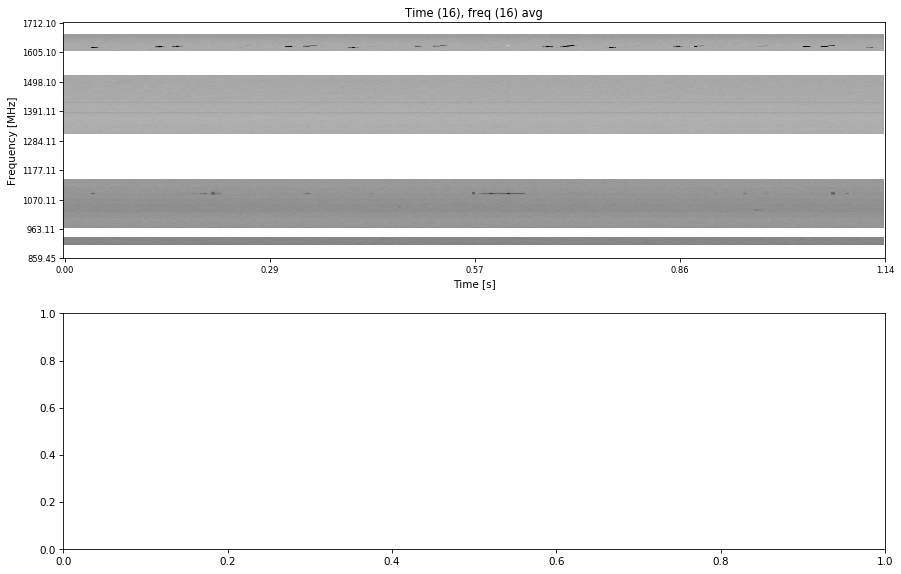

Dedispersion took 0.32s
Finding a match for file 2019_06_19_20:28:34.fil
UTC: 2019_06_19_20:28:34 -> MJD: 58653.85317984
58653.8531798439 -> 58653.8531914180, 58653.8531712963
Kill me...
Found 5 matching candidates
./1226/Filfiles//beam-0/2019_06_19_20:27:52.spccl
Read 3454 time samples
Dedispersion took 0.15s
Finding a match for file 2019_06_19_20:28:38_1.fil
UTC: 2019_06_19_20:28:38_1 -> MJD: 58653.85322332
58653.8532233246 -> 58653.8532348987, 58653.8532175926
Kill me...
Found 4 matching candidates
./1226/Filfiles//beam-0/2019_06_19_20:27:52.spccl
Read 2849 time samples
Dedispersion took 0.14s
Finding a match for file 2019_06_19_20:28:28.fil
UTC: 2019_06_19_20:28:28 -> MJD: 58653.85311105
58653.8531110473 -> 58653.8531226214, 58653.8531018519
Kill me...
Found 22 matching candidates
./1226/Filfiles//beam-0/2019_06_19_20:27:52.spccl
Read 3858 time samples
Dedispersion took 0.15s
Finding a match for file 2019_06_19_20:28:15.fil
UTC: 2019_06_19_20:28:15 -> MJD: 58653.85295534
58653.8529

In [90]:
watcher = Watcher("./1226/Filfiles/", True, True)
watcher.Watch()
#watcher.GetNewSpcclFiles()

In [ ]:
files = os.scandir('./Candfiles/')
latest = 0
new_files = []
for file in files:
    print(file.name)
    print(file.stat().st_mtime)
    if (file.stat().st_mtime > latest):
        new_files.append([file.name, file.stat().st_mtime])

print(new_files)

latest = min(new_files, key=lambda nf: nf[1])
print(latest)

for nf in new_files:rsync --progress -e "ssh tuse ssh" tpn-0-9:/state/partition1/node_controller/output/beam00/2019_06_19_20:29:13.fil
    print(nf[1])
    
print(len(new_files))

In [ ]:
array1d = np.arange(64)
print(array1d)

In [ ]:
array2d = array1d.reshape((8, -1))
print(array2d)

In [ ]:
array3d = array2d.reshape((-1, 2, 8))
print(array3d)

In [ ]:
np.sum(array3d, axis=1)

In [ ]:
np.linspace(0, 4096, num=9)

In [ ]:
numbers = np.arange(6) * 306.24299e-06
fmt = lambda x: "{:.2f}%".format(x)
strings = [fmt(label) for label in numbers]
print(strings)

In [ ]:
from astropy.time import Time

In [ ]:
filfile = '2019_06_17_16:22:21.fil'[:-4]
filsplit = filfile.split('_')
filtime = filsplit[0] + '-' + filsplit[1] + '-' + filsplit[2] + 'T' + filsplit[3]
print(filtime)
aptime = Time(filtime, format='isot', scale='utc')

In [ ]:
print(aptime.mjd)
print(aptime.mjd + 0.5 / 86400.0)
padded_mjd = aptime.mjd + 0.5 / 86400.0
padded_start_mjd = 

In [ ]:
header_names = ['MJD', 'DM', 'Width', 'SNR']
skipcands = 1
test_cands = pd.read_csv('1226/Candfiles/2019_06_17_16:22:21_1.spccl', sep='\s+', names=header_names, skiprows=skipcands)
selected=test_cands.loc[test_cands['MJD'] <= padded_mjd]
print(selected)
first_cand = test_cands.iloc[0]

In [ ]:
print(aptime.mjd + 1.0 / 86400.0)

In [ ]:
first_mjd = first_cand['MJD']

In [ ]:
print(first_mjd)
print(first_mjd + 1.0 / 86400.0)

In [ ]:
beam_dir = '1226/Filfiles/beam-' + str(0) + '/'
fil_files = os.scandir(beam_dir)
times = []
for ff in fil_files:
    filsplit = ff.name[:-4].split('_')
    print(filsplit)
    filtime = filsplit[0] + '-' + filsplit[1] + '-' + filsplit[2] + 'T' + filsplit[3]
    print(filtime)
    aptime = Time(filtime, format='isot', scale='utc')
    print(aptime.mjd)
    times.append(aptime.mjd)
    
print(times)

In [ ]:
header_names = ['MJD', 'DM', 'Width', 'SNR']
skipcands = 1
test_cands = pd.read_csv('1226/Candfiles/2019_06_19_20:27:52.spccl', sep='\s+', names=header_names, skiprows=skipcands)
mjd_pad = 0.5 / 86400.0

selected = test_cands.loc[(test_cands['MJD'] >= times[0]) & (test_cands['MJD'] <= times[0] + 2 * mjd_pad)]
selected.head()

In [ ]:
best = selected.loc[selected['SNR'].idxmax()]

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['MJD'], y=selected['DM'], s=10, c=selected['SNR'])

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['DM'], y=selected['SNR'], s=10, c=selected['Width'])

In [ ]:
header_names = ['MJD', 'DM', 'Width', 'SNR']
skipcands = 1
test_cands = pd.read_csv('1226/Candfiles/2019_06_19_20:27:52.spccl', sep='\s+', names=header_names, skiprows=skipcands)
mjd_pad = 0.5 / 86400.0

selected = test_cands.loc[(test_cands['MJD'] >= times[0]) & (test_cands['MJD'] <= times[0] + 2 * mjd_pad)]

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['MJD'], y=selected['DM'], s=10, c=selected['SNR'])

In [ ]:
header_names = ['MJD', 'DM', 'Width', 'SNR']
skipcands = 1
test_cands = pd.read_csv('1226/Candfiles/2019_06_19_20:27:52.spccl', sep='\s+', names=header_names, skiprows=skipcands)
mjd_pad = 0.5 / 86400.0

selected = test_cands.loc[(test_cands['MJD'] >= times[1]) & (test_cands['MJD'] <= times[1] + 2 * mjd_pad)]

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['MJD'], y=selected['DM'], s=10, c=selected['SNR'])

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['DM'], y=selected['SNR'], s=10, c=selected['Width'])

In [ ]:
header_names = ['MJD', 'DM', 'Width', 'SNR']
skipcands = 1
test_cands = pd.read_csv('1226/Candfiles/2019_06_19_20:27:52.spccl', sep='\s+', names=header_names, skiprows=skipcands)
mjd_pad = 0.5 / 86400.0

selected = test_cands.loc[(test_cands['MJD'] >= times[2]) & (test_cands['MJD'] <= times[2] + 2 * mjd_pad)]

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['MJD'], y=selected['DM'], s=10, c=selected['SNR'])

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['DM'], y=selected['SNR'], s=10, c=selected['Width'])

In [ ]:
header_names = ['MJD', 'DM', 'Width', 'SNR']
skipcands = 1
test_cands = pd.read_csv('1226/Candfiles/2019_06_19_20:27:52.spccl', sep='\s+', names=header_names, skiprows=skipcands)
mjd_pad = 0.5 / 86400.0

selected = test_cands.loc[(test_cands['MJD'] >= times[3]) & (test_cands['MJD'] <= times[3] + 2 * mjd_pad)]

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['MJD'], y=selected['DM'], s=10, c=selected['SNR'])

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['DM'], y=selected['SNR'], s=10, c=selected['Width'])

In [ ]:
header_names = ['MJD', 'DM', 'Width', 'SNR']
skipcands = 1
test_cands = pd.read_csv('1226/Candfiles/2019_06_19_20:27:52.spccl', sep='\s+', names=header_names, skiprows=skipcands)
mjd_pad = 0.5 / 86400.0

selected = test_cands.loc[(test_cands['MJD'] >= times[1]) & (test_cands['MJD'] <= times[1] + 2 * mjd_pad)]

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['MJD'], y=selected['DM'], s=10, c=selected['SNR'])

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

ax.ticklabel_format(useOffset=False)
ax.scatter(x=selected['DM'], y=selected['SNR'], s=10, c=selected['Width'])

In [ ]:
data = np.ones((4, 6))#
print(data)
mask = np.array([1, 0, 0, 1])
print(mask)

In [ ]:
data * mask[:, np.newaxis]

In [ ]:
import struct
filmjd = np.fromfile('1226/Filfiles/beam-0/2019_06_19_20:29:13.fil')[96:104]
mjd = struct.unpack('<d', filmjd)[122]
print(mjd)
print(filmjd)

In [ ]:
with open('1226/Filfiles/beam-0/2019_06_19_20:29:13.fil', mode='rb') as file: # b is important -> binary
    fileContent = file.read(114)
    mjd = struct.unpack('d', file.read(8))[0]

print(mjd)

In [14]:
timeavg = 16
freqavg = 16

mask = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

fildata = np.reshape(np.fromfile('1226/Filfiles/beam-0/2019_06_19_20:28:10.fil', dtype='B')[136:], (-1, 4096)).T

print(fildata[:, 0])



timesamples = int(np.floor(fildata.shape[1] / timeavg) * timeavg)
filtimeavg = fildata[:, :timesamples].reshape(fildata.shape[0], (int)(timesamples / timeavg), timeavg).sum(axis=2)
fildata = fildata * mask[:, np.newaxis]


# Frequency average the data
frequencies = int(np.floor(fildata.shape[0] / freqavg) * freqavg)
filfreqavg = fildata[:frequencies, :timesamples].reshape(-1, freqavg, timesamples).sum(axis=1)

filbothavg = filfreqavg.reshape(filfreqavg.shape[0], (int)(timesamples / timeavg), timeavg).sum(axis=2) / timeavg / freqavg


notzero = (filbothavg[:,0])[np.where(filbothavg[:,0]!=0)[0]]

filband = np.mean(filbothavg, axis=1)
filbothavg = filbothavg - filband[:, np.newaxis]

print(np.mean(filbothavg[:, 0]))
print(np.mean(notzero))

datamean = np.mean(notzero)
datastd = np.std(notzero)

print(datastd)

ctop = int(np.ceil(datamean + 1.25 * datastd))
cbottom = int(np.floor(datamean - 0.5 * datastd))

print(ctop)
print(cbottom)


[ 88  87  87 ... 128 128 128]
-0.00606614961398852
94.57594058388158
7.052398518172931
104
91


Text(81.5104,0.5,'Frequency [MHz]')

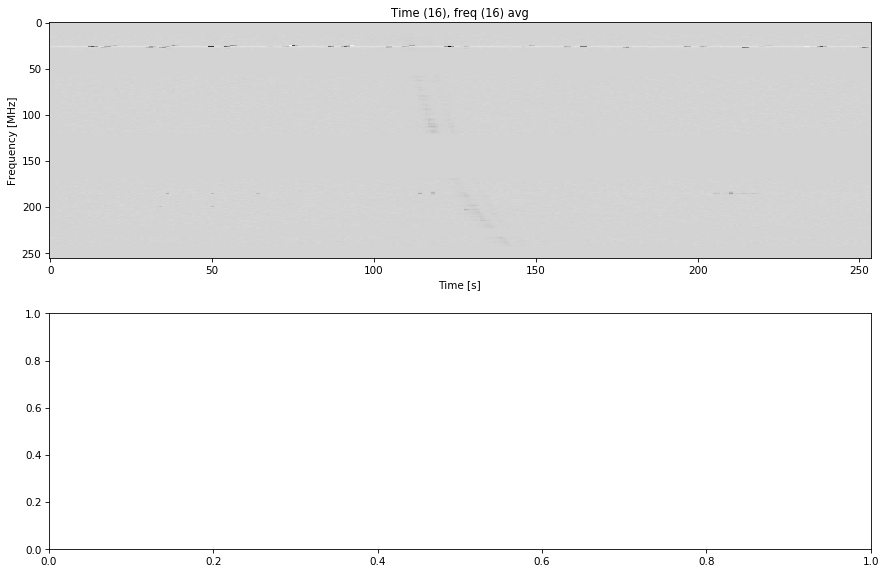

In [11]:
fil_fig, fil_axis = plt.subplots(2, 1, figsize=(11.69,8.27), dpi=75)
fil_fig.tight_layout(h_pad=3.25, rect=[0, 0.03, 1, 0.95])

cmap = 'binary'

axboth = fil_axis[0]
axboth.imshow(filbothavg, interpolation='none', aspect='auto', cmap=cmap)
axboth.set_title('Time (' + str(timeavg) + '), freq (' + str(freqavg) + ') avg', fontsize=11)
axboth.set_xlabel('Time [s]', fontsize=10)
axboth.set_ylabel('Frequency [MHz]', fontsize=10)

In [6]:
filband = np.mean(filbothavg, axis=1)

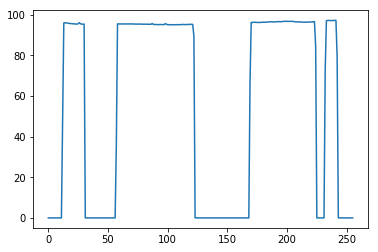